In [1]:
from __future__ import annotations

import particle_in_a_box as pib
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve, brentq
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MultipleLocator
import default_plot as dp

plt.rcParams["text.usetex"] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Dejavu Serif'
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams["xtick.direction"] = "inout"
plt.rcParams["ytick.direction"] = "inout"
plt.rcParams['axes.linewidth'] = 0.7
plt.rcParams['xtick.major.width'] = 0.7
plt.rcParams['ytick.major.width'] = 0.7


## Color Scheme

In [2]:
import colorsys as cs
light_blue = cs.hls_to_rgb(235/360, 0.87, 1)
less_light_blue = cs.hls_to_rgb(235/360, 0.77, 1)
mid_blue = cs.hls_to_rgb(235/360, 0.67, 1)
dark_blue = cs.hls_to_rgb(235/360, 0.37, 1)
light_red = cs.hls_to_rgb(0, 0.87, 1)
mid_red = cs.hls_to_rgb(0, 0.67, 1)
dark_red = cs.hls_to_rgb(0, 0.37, 1)

# Generic Momentum Distribution Visualization

## Initializing Generic Particle-in-a-Box state

In [4]:
# Demo State
L = np.pi
m = 1
gamma = 10000
states = [5]
amps = [1]
theta = 0

pib_state_1 = pib.Particle_in_Box_State("symmetric", L, m, states, amps, gamma, 0)
pib_state_2 = pib.Particle_in_Box_State("symmetric", L, m, states, amps, gamma, np.pi)


## Create Plots showing the single energy state momentum distributions for different values of theta

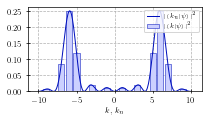

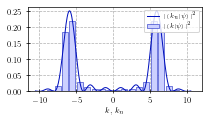

In [5]:
fig1 = plt.figure(tight_layout = True, figsize=(3,1.8))
p1 = dp.Momentum_Space_Plot(pib_state_1, fig1)
p1.set_n_bound(10)
p1.plot(0)
p1.k_lines[0].set_label(r"$\vert \left \langle k_n \middle \vert \psi \right \rangle \vert^2$")
p1.k_lines[0].set_linewidth(1)
p1.k_bars.set_label(r"$\vert \left \langle k \middle \vert \psi \right \rangle \vert^2$")
p1.k_lines[0].set_zorder(4)
for b in p1.k_bars:
    b.set_zorder(3)
p1.axis.legend(loc="upper right", fontsize=6)
p1.axis.set_ylabel(None)
p1.axis.yaxis.set_major_locator(MultipleLocator(0.05))
p1.axis.grid(True, linewidth=0.7, linestyle="--", zorder=0)
plt.savefig("..\\Thesis\\Figures\\dirichlet_5th_state_momentum_distr_theta_0.pdf")

fig2 = plt.figure(tight_layout = True, figsize=(3,1.8))
p2 = dp.Momentum_Space_Plot(pib_state_2, fig2)
p2.set_n_bound(10)
p2.plot(0)
p2.k_lines[0].set_label(r"$\vert \left \langle k_n \middle \vert \psi \right \rangle \vert^2$")
p2.k_lines[0].set_linewidth(1)
p2.k_bars.set_label(r"$\vert \left \langle k \middle \vert \psi \right \rangle \vert^2$")
#p1.axis.tick_params('y', left=False, right=True, labelleft=False, labelright=True)
p2.axis.legend(loc="upper right", fontsize=6)
p2.axis.set_ylabel(None)
p2.k_lines[0].set_zorder(4)
for b in p2.k_bars:
    b.set_zorder(3)
p2.axis.legend(loc="upper right", fontsize=6)
p2.axis.set_ylabel(None)
p2.axis.yaxis.set_major_locator(MultipleLocator(0.05))
p2.axis.grid(True, linewidth=0.7, linestyle="--", zorder=0)
plt.savefig("..\\Thesis\\Figures\\dirichlet_5th_state_momentum_distr_theta_pi.pdf")

# Wrapping Wavefunctions

## Define Classes to Help visualizing the process of wrapping free particle waves into the box 

In [6]:
class wavepacket:
    def __init__(self, k_0, alpha, x_0) -> None:
        self.k_0 = k_0
        self.alpha = alpha
        self.x_0 = x_0

    def __call__(self, x) -> np.ndarray:
        return np.power(self.alpha/np.pi, 1/4)*np.exp(1j*self.k_0*(x-self.x_0))*np.exp(-self.alpha/2*(x-self.x_0)**2)

class phi:
    def __init__(self, n, L, sign, func) -> None:
        self.n = n
        self.L = L 
        self.func = func
        self.sign = 1 if sign=="plus" else -1
    
    def sumup(self, x):
        out = np.zeros(np.shape(x), dtype=complex)
        for k in range(0, self.n//2+1):
            out += self.func(x + self.sign*2*k*self.L)

        for k in range(0, (self.n-1)//2+1):
            out -= self.func(-x + self.sign*(2*k+1)*self.L)

        return out        
        
    def __call__(self, x):
        #norm = quad(lambda x: np.abs(self.sumup(x))**2, -np.inf, np.inf)[0]
        norm = 1
        return self.sumup(x)/np.sqrt(norm)

    def any_step(self, n, x):
        return self.func(x*(-1)**(n) + self.sign*(n)*self.L)

    def next_step(self, x):
        return self.any_step(self.n+1, x)

    def current_step(self, x):
        return self.any_step(self.n, x)
    
    def prev_step(self, x):
        return self.any_step(self.n-1, x)

## Create visualization of wrapping process

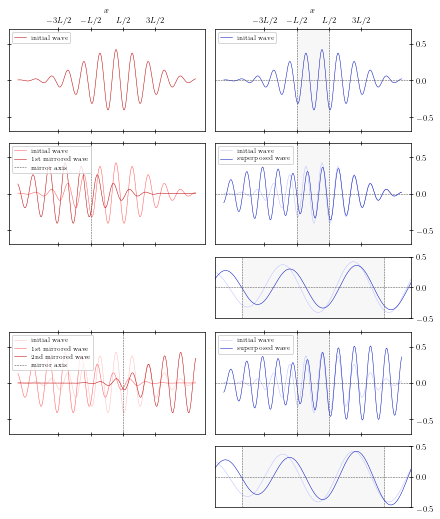

In [7]:
L = np.pi
nrows=3
fig = plt.figure(constrained_layout=True, figsize=(6,7.1))
gs = fig.add_gridspec(nrows=2*nrows-1, ncols=2, height_ratios=(1, 1, 0.6, 1, 0.6))
ax = [[],[],[]]

impose_lines = []

x_lim_1 = L/2*(5.5)
x_lim_2 = L
x_lim_2 = x_lim_1*0.25

x = np.linspace(-x_lim_1, x_lim_1, 500)
wave = wavepacket(4, 0.1, 0.9)
phi_m = phi(0, L, "minus", wave)

init_ax = fig.add_subplot(gs[0,1])
init_ax.plot(x, np.real(wave(x)), c=dark_blue, lw=0.5, label="initial wave")
init_ax.legend(loc="upper left", fontsize=6)
init_ax.set_ylim([-0.7, 0.7])
init_ax.axvspan(-L/2, L/2, color="0.97")
init_ax.axvline(-L/2, color="0.3", linewidth=0.5, linestyle="--")
init_ax.axvline(L/2, color="0.3", linewidth=0.5, linestyle="--")
init_ax.axhline(0, color="0.3", linewidth=0.5, linestyle="--")
init_ax.xaxis.tick_top()
init_ax.yaxis.tick_right()
init_ax.tick_params(axis="both", right=True, labelleft=False, labelbottom=False, bottom=True)
init_ax.xaxis.set_label_position("top")
init_ax.yaxis.set_label_position("right")
init_ax.set_xlabel("$x$")
init_ax.set_yticks([-0.5, 0, 0.5])
init_ax.set_xticks([-3*L/2, -L/2, L/2, 3*L/2])
init_ax.set_xticklabels(["$-3L/2$", "$-L/2$", "$L/2$", "$3L/2$"])
#init_ax.set_ylabel("real part")


init_ax_r = fig.add_subplot(gs[0,0], sharey=init_ax)
init_ax_r.plot(x, np.real(wave(x)), c=dark_red, lw=0.5, label="initial wave")
init_ax_r.legend(loc="upper left", fontsize=6)
init_ax_r.xaxis.tick_top()
init_ax_r.tick_params(axis="both", labelbottom=False, bottom=True, labelleft=False)
init_ax_r.xaxis.set_label_position("top")
init_ax_r.set_xlabel("$x$")
init_ax_r.set_xticks([-3*L/2, -L/2, L/2, 3*L/2])
init_ax_r.set_xticklabels(["$-3L/2$", "$-L/2$", "$L/2$", "$3L/2$"])


for i in range(1, nrows):
    ax[0].append(fig.add_subplot(gs[2*i-1,0], sharex=init_ax, sharey=init_ax))
    ax[1].append(fig.add_subplot(gs[2*i-1,1], sharex=init_ax_r, sharey=init_ax_r))
    ax[2].append(fig.add_subplot(gs[2*i,1]))
    axis_0 = ax[0][-1]

    if i >= 2:
        impose_lines.append(axis_0.plot(x, np.real(phi_m.prev_step(x)), c=light_red, lw=0.5))
    impose_lines.append(axis_0.plot(x, np.real(phi_m.current_step(x)), c=mid_red, lw=0.5))
    impose_lines.append(axis_0.plot(x, np.real(phi_m.next_step(x)), c=dark_red, lw=0.5))
    axis_0.axvline((L/2)*(-1)**i, color="0.3", linewidth=0.5, linestyle="--", label="mirror axis")
    axis_0.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labelleft=False)

    phi_m.n += 1
    for i in range(2):
        axis = ax[i+1][-1]
        axis.plot(x, np.real(wave(x)), c=light_blue, lw=0.5, label="initial wave")
        axis.plot(x, np.real(phi_m(x)), c=dark_blue, lw=0.5, label="superposed wave")
        axis.axvspan(-L/2, L/2, color="0.97")
        axis.axvline(-L/2, color="0.3", linewidth=0.5, linestyle="--")
        axis.axvline(L/2, color="0.3", linewidth=0.5, linestyle="--")
        axis.axhline(0, color="0.3", linewidth=0.5, linestyle="--")
        axis.tick_params(axis="both", left=False, right=True, top=True, labelleft=False, labelright=True, bottom=True, labelbottom=False)
    
    ax[1][-1].legend(loc="upper left", fontsize=6)
    ax[2][-1].set_xlim([-x_lim_2, x_lim_2])
    ax[2][-1].set_ylim([-0.5, 0.5])
    ax[2][-1].tick_params(axis="both", bottom=False, top=False, labelbottom=False)

impose_lines[0][0].set_label("initial wave")
impose_lines[1][0].set_label("1st mirrored wave")
impose_lines[2][0].set_label("initial wave")
impose_lines[3][0].set_label("1st mirrored wave")
impose_lines[4][0].set_label("2nd mirrored wave")

for i in range(0, nrows-1):
    ax[0][i].legend(loc="upper left", fontsize=6)


plt.savefig("..\\Thesis\\Figures\\wrapping_dirichlet.pdf")


# Bouncing Gaussian

## Initializing bouncing Gaussian

In [8]:
import Special_States as sp
case = "dirichlet"
L = np.pi
m = 1
a = L/10
l_0 = 80
l_range = 25
T = 4*m*L**2/np.pi

gaussian = sp.Bouncing_Gaussian(case, L, m, l_0, l_range, a)

## Helper class to construct envelopes of barplots
This is deprecated now, as it turned out that there already exist a much easier way of crating stepped function using the drawstyle keyword

In [9]:
class step_function:
    def __init__(self, func, num):
        self.func = func
        self.num = num

    def __call__(self, x):
        width = (x[-1]-x[0])/self.num
        ins = []
        outs = np.array([])
        outs_x = np.array([])
        
        for i in range(self.num):
            point = x[0]+width*i
            ins.append(x[(x >= point-width/2)*(x <= point+width/2)])
            outs = np.append(outs, np.full(np.shape(ins[-1]),self.func(point)))
            outs_x = np.append(outs_x, ins[-1])
    
        return outs_x, outs

## Primitive helper function to create Bouncing Gaussian snapshots

In [10]:
def the_snapshots_we_deserve(gaussian: pib.Particle_in_Box_State, time_points: np.array, save=True):
    fig = plt.figure(constrained_layout=True, figsize=(2.8,2.6))
    gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[1,1])
    L = gaussian.L

    position_plot = dp.Position_Space_Plot(gaussian, fig, gs, [0,0])
    position_plot.set_resolution(5000)
    position_plot.expectation_value = True

    momentum_plot = dp.Discrete_Momentum_Space_Plot(gaussian, fig, gs, [1,0])
    momentum_plot.set_n_bound(90)
    momentum_plot.expectation_value = True
    momentum_plot._dark_color = (0,0,0,0)

    combined_plot = dp.Multi_Plot(position_plot, momentum_plot)

    if gaussian.case == "dirichlet":
        subscript = r"{D}"
    elif gaussian.case == "neumann":
        subscript = r"{N}"
    elif gaussian.case == "dirichlet_neumann":
        subscript = r"{DN}"

    for t in time_points:
        combined_plot.clear()
        position_plot.axis.set_ylabel(None)
        position_plot.axis.set_xlabel(None)
        #position_plot.axis.xaxis.set_label_position("top")
        position_plot.axis.tick_params(axis="x", labelbottom=False, bottom=False, top=True, labeltop=True)
        #position_plot.axis.set_yticks([0, 0.5, 1, 1.5])
        position_plot.axis.set_xticks([-L/2, 0, L/2])
        position_plot.axis.set_xticklabels(["$-L/2$", "$0$", "$L/2$"])
        position_plot.axis.set_ylim([-0.08979356106230174, 2])
        position_plot.axis.yaxis.set_major_locator(MultipleLocator(0.5))
        momentum_plot.axis.set_ylabel(None)
        momentum_plot.axis.set_xlabel(None)
        momentum_plot.axis.set_ylim([0, 0.25])
        momentum_plot.axis.set_xticks([-80, 0, 80])
        momentum_plot.axis.set_xticklabels(["$-k_0$", "$0$", "$k_0$"])
        combined_plot.plot(t)

        position_plot.x_lines[0].set_linewidth(0.75)
        position_plot.x_lines[0].set_label(r"$| \langle x | \psi_" + subscript + r"(t) \rangle |^2$")
        position_plot.x_exp_line.set_label(None)
        momentum_plot.k_bars.set_label(r"$| \langle k_n | \psi_" + subscript + r"(t) \rangle |^2$")
        momentum_plot.k_exp_line.set_label(None)
        momentum_plot.axis.legend(loc="upper left", fontsize=8)
        position_plot.axis.legend(loc="upper left", fontsize=8)

        k_bound = gaussian.boundary_lib.get_kn(momentum_plot.n_bound*(1.0000001))
        k_range = np.linspace(-k_bound, k_bound, 10000)
        func = lambda k: np.abs(gaussian.k_space_wavefunction(k, t))**2
        num_points = np.size(momentum_plot.n)

        """stepped = step_function(func, num_points)
        momentum_plot.axis.plot(*stepped(k_range), color=dark_blue, linewidth=0.25)"""
        
        n = momentum_plot.n
        kn = momentum_plot.kn
        momentum_plot.axis.plot(kn, np.abs(gaussian.new_k_space_wavefunction(n,t))**2, color=dark_blue, linewidth=0.25, drawstyle="steps-mid")
        if save:
            plt.savefig("..\\Thesis\\Figures\\"+gaussian.case+"_gaussian_"+str(t)+".pdf")

## Creating snapshots for Dirichlet boundaries

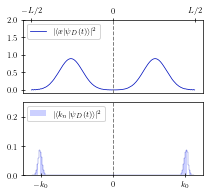

In [11]:
t_points = [0, 0.015, T/2, T/4, T/4-0.01]
gaussian.case = "dirichlet" 
the_snapshots_we_deserve(gaussian, t_points)

## Creating snapshots for Neumann boundaries

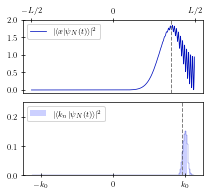

In [12]:
t_points = [T/4-0.01, 0.014]
gaussian.case = "neumann"
the_snapshots_we_deserve(gaussian, t_points)

## Create snapshots for mixed Dirichlet-Neumann boundaries

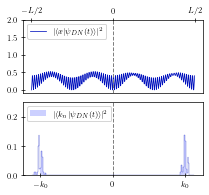

In [13]:
t_points = [T/8, T/8-0.005]
gaussian.case = "dirichlet_neumann"
the_snapshots_we_deserve(gaussian, t_points)

# Energy Spectra

## Helper Classes for Nummerical Determination and Plotting of the Spectra

In [10]:
class gamma_to_kl_base:
    def __init__(self, L: float, l = None) -> None:
        self.l = l
        self.L = L
    
    def get_kl(self) -> None:
        pass

    def set_l(self, new_l):
        self.l = new_l
        return self

class gamma_to_kl_symmetric(gamma_to_kl_base):
    def __init__(self, L: float, l = None) -> None:
        super().__init__(L, l)
        self._pos_energy_even_state_eq = lambda gammaL, kL: gammaL - np.arctan(kL*np.tan(kL/2))
        self._pos_energy_odd_state_eq = lambda gammaL, kL: gammaL + np.arctan(kL/np.tan(kL/2))
        self._neg_energy_even_state_eq = lambda gammaL, kappaL: gammaL + np.arctan(kappaL*np.tanh(kappaL/2))
        self._neg_energy_odd_state_eq = lambda gammaL, kappaL: gammaL + np.arctan(kappaL/np.tanh(kappaL/2))
        self._eps = np.finfo(np.float32).eps

    def get_kl(self, gamma) -> None:
        gammaL = np.arctan(gamma*self.L)
        eps = self._eps
        l = self.l

        if l == 0:
            gammaL_greater_zero = gammaL[gamma > 0]
            gammaL_smaller_zero = gammaL[gamma < 0]

            length_greater_zero = np.size(gammaL_greater_zero)

            transc_eq_pos = self._pos_energy_even_state_eq
            transc_eq_neg = self._neg_energy_even_state_eq

            kL_guess_greater_zero = np.linspace(0.5, 1, length_greater_zero)*np.pi
            kappaL_guess_smaller_zero = -np.tan(gammaL_smaller_zero)

            kL_solve_greater_zero = fsolve(lambda kL: transc_eq_pos(gammaL_greater_zero, kL), kL_guess_greater_zero)
            kappaL_solve_smaller_zero = fsolve(lambda kappaL: transc_eq_neg(gammaL_smaller_zero, kappaL), kappaL_guess_smaller_zero)

            return np.concatenate((kappaL_solve_smaller_zero*1j/L, kL_solve_greater_zero/L))

        elif l == 1:
            gammaL_greater_mtwo = gammaL[gamma > -2/L]
            gammaL_smaller_mtwo = gammaL[gamma < -2/L]

            length_greater_mtwo = np.size(gammaL_greater_mtwo)

            transc_eq_pos = self._pos_energy_odd_state_eq
            transc_eq_neg = self._neg_energy_odd_state_eq

            kL_guess_greater_mtwo = np.full(length_greater_mtwo, 1)*np.pi
            kappaL_guess_smaller_mtwo = -np.tan(gammaL_smaller_mtwo)

            kL_solve_greater_mtwo = fsolve(lambda kL: transc_eq_pos(gammaL_greater_mtwo, kL), kL_guess_greater_mtwo)
            kappaL_solve_smaller_mtwo = fsolve(lambda kappaL: transc_eq_neg(gammaL_smaller_mtwo, kappaL), kappaL_guess_smaller_mtwo)

            return np.concatenate((kappaL_solve_smaller_mtwo*1j/L, kL_solve_greater_mtwo/L))

        else:
            if l%2 == 0:
                transc_eq = self._pos_energy_even_state_eq
            else:
                transc_eq = self._pos_energy_odd_state_eq

            kL_guess = np.full(np.size(gamma), l*np.pi)
            kL_solve = fsolve(lambda kL: transc_eq(gammaL, kL), kL_guess)

            return kL_solve/L
    
class gamma_to_kl_antisymm(gamma_to_kl_base):
    def __init__(self, L: float, l = None) -> None:
        super().__init__(L, l)

    def get_kl(self, gamma) -> None:
        l = self.l

        if self.l == 0:
            return 1j*np.abs(gamma)
        else:
            return np.full(np.shape(gamma), l*np.pi/self.L)

class mini_ax_handler:
    def __init__(self, axes, fig, gs, row_offset):
        self.axes = axes
        self.fig = fig
        self.gs = gs
        self.offset = row_offset

    def append_ax(self, row, col, share=False):
        if share:
            self.axes[col].append(self.fig.add_subplot(self.gs[row+self.offset, col], sharex=self.axes[0][0], sharey=self.axes[0][0]))
        else:
            self.axes[col].append(self.fig.add_subplot(self.gs[row+self.offset, col]))

class Energy_Spectrum_Plot:
    def __init__(self, case: str, L: float,  state = None) -> None:
        self.L = L
        self.l = state
        self.case = case
        if case == "symmetric":
            self.gamma_to_kl_mapper = gamma_to_kl_symmetric(L)
        elif case == "anti_symmetric":
            self.gamma_to_kl_mapper = gamma_to_kl_antisymm(L)

    def set_L(self, new_L):
        self.L = new_L
        self.gamma_to_kl_mapper.L = new_L

    def plot_both(self, gamma, states_spec):
        fig = plt.figure(constrained_layout=True, figsize=(5.4, 7))
        gs = fig.add_gridspec(nrows=5, ncols=4, height_ratios=(4, 1, 1, 1, 1))
        spec_ax = fig.add_subplot(gs[0, :])
        self.plot_spectrum(gamma, states_spec, spec_ax)
        self.plot_eigenstates([0, 1, 2, 3], fig, gs)
        return spec_ax

    def plot_spectrum(self, gamma, states, ax=None):
        L = self.L
        if ax == None:
            fig = plt.figure(tight_layout=True, figsize=(5.4, 3.2))
            ax = fig.add_subplot()
        ax.set_ylim([-4,16])
        ax.set_xlim([-np.pi/2-10*eps, np.pi/2+10*eps])
        ax.set_yticks([-4, 0, 1, 4, 9, 16])
        ax.set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
        ax.set_xticklabels(["$-\pi/2$", "$-\pi/4$", "$0$", "$\pi/4$", "$\pi/2$",])
        ax.grid(True, linewidth=0.7, linestyle="--")
        ax.set_xlabel(r"$\arctan(\gamma L)$")
        ax.set_ylabel(r"Energy in units of $\frac{\pi^2}{2mL^2}$", labelpad=0)
        ax.yaxis.set_minor_locator(MultipleLocator(1))
        spectrum = self.gamma_to_kl_mapper
        for i in states:
            col = dark_blue if i%2 == 0 else mid_blue
            ax.plot(np.arctan(gamma*L), np.real(spectrum.set_l(i).get_kl(gamma)**2)*(L/np.pi)**2, c=col, linewidth=1)
        
        return ax

    def plot_eigenstates(self, states, fig=None, gs=None):
        m = 1
        eps = 10**(-9)
        base_state = pib.Particle_in_Box_Immediate_Mode(self.case, L, m, 0, 1, gamma=1)

        gamma_samples = [-150, -2/L+eps, 0+eps, 150]
        gamma_labels = [r"$\gamma \to -\infty$", r"$\gamma = -2/L$", r"$\gamma = 0$", r"$\gamma \to \infty$"]

        x = np.linspace(-L/2, L/2, 500)
        axes = []

        if fig == None:
            fig = plt.figure(constrained_layout=True, figsize=(5.4, 3.6))
            gs = fig.add_gridspec(nrows=len(states), ncols=4)
            append_handler = mini_ax_handler(axes, fig, gs, 0)
        else:
            append_handler = mini_ax_handler(axes, fig, gs, 1)
        
        for j in range(4):
            axes.append([])
            base_state.gamma = gamma_samples[j]
            for l in range(len(states)):
                if l==0 and j==0:
                    append_handler.append_ax(l, j)
                else:
                    append_handler.append_ax(l, j, True)

                base_state.reset()
                base_state.add_state(states[l], 1)
                ax = axes[j][l]
                ax.set_ylim([-1,1])
                ax.tick_params(axis="both", bottom=False, labelbottom=False, left=False, labelleft=False)

                ax.axvline(0, color="#b0b0b0", linewidth=0.7, linestyle="--")
                ax.axhline(0, color="#b0b0b0", linewidth=0.7, linestyle="--")
                col_re = dark_blue if l%2 == 0 else mid_blue
                
                ax.plot(x, np.real(base_state.x_space_wavefunction(x, 0)), color=col_re, linewidth=1)
                ax.plot([],[], marker="o", color=col_re, label="Re", linestyle="None", markersize = 2)
                
                if j == 0:
                    ax.tick_params(axis="both", left=True, labelleft=True)
                    ax.set_yticks([-0.8,0, 0.8])
                if l == len(states)-1:
                    ax.tick_params(axis="both", bottom=True, labelbottom=True)
                    ax.set_xticks([-L/2, 0, L/2])
                    ax.set_xticklabels([r"$-\frac{L}{2}$", "$0$", r"$\frac{L}{2}$"], fontsize=8)
                if l == 0:
                    ax.xaxis.set_label_position("top")
                    ax.set_xlabel(gamma_labels[j], labelpad=10)
                if j == 3:
                    ax.yaxis.set_label_position("right")
                    secax = ax.secondary_yaxis("right")
                    secax.set_yticks([0])
                    secax.set_yticklabels(["$l = " + str(states[l]) + "$"], fontsize=8)
                    secax.tick_params(axis="y", pad=10, right=False)

## Symmetric Spectrum

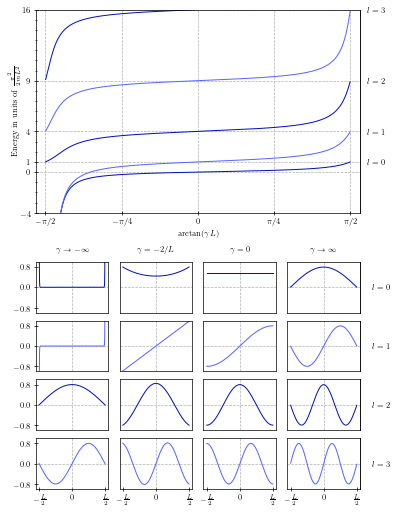

In [11]:
L = np.pi
eps = 0.01
gamma = np.tan(np.linspace(-np.pi/2+eps, np.pi/2-eps, 800))
symmetric_spectrum = Energy_Spectrum_Plot("symmetric", L)
spec_ax = symmetric_spectrum.plot_both(gamma, [0,1,2,3,4])
secax = spec_ax.secondary_yaxis("right")
secax.set_yticks([1, 4, 9, 16])
secax.set_yticklabels(["$l=0$", "$l=1$", "$l=2$", "$l=3$"])
secax.tick_params(axis="y", right=False, pad=5)
plt.savefig("..\\Thesis\\Figures\\symmetric_spec_states.pdf")

## Anit-Symmetric Spectrum

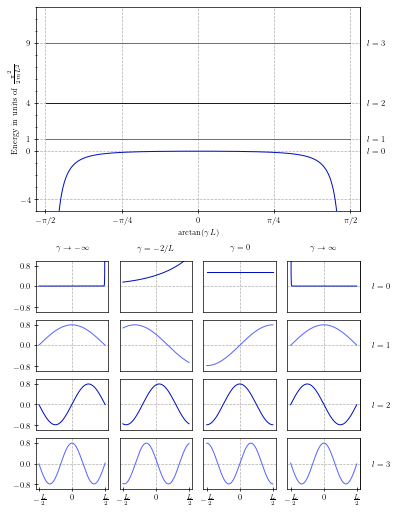

In [12]:
anti_symmetic_spectrum = Energy_Spectrum_Plot("anti_symmetric", L)
spec_ax = anti_symmetic_spectrum.plot_both(gamma, [0,1,2,3])
spec_ax.set_ylim([-5, 12])
secax = spec_ax.secondary_yaxis("right")
secax.set_yticks([0, 1, 4, 9])
secax.set_yticklabels(["$l=0$", "$l=1$", "$l=2$", "$l=3$"])
secax.tick_params(axis="y", right=False, pad=5)
plt.savefig("..\\Thesis\\Figures\\anti_symmetric_spec_states.pdf")


# Delta Distribution - Dirichlet Kernel

In [17]:
class Dirichlet_Kernel:
    def __init__(self, n, L, x_0) -> None:
        self.n = n
        self.L = L
        self.x_0 = x_0

    def set_x_0(self, new_x_0):
        self.x_0 = new_x_0
        return self
    
    def set_n(self, n_new):
        self.n = n_new
        return self
    
    def __call__(self, x):
        out = np.zeros(np.shape(x), dtype=complex)
        for k in range(-self.n, self.n+1):
            out += np.exp(1j*k*2*np.pi/self.L*(x-self.x_0))
        return out

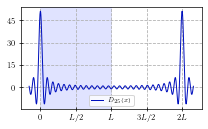

In [18]:
L = np.pi
dirichlet_Kernel = Dirichlet_Kernel(1, 2*L, np.pi)

eps = 0.5
x = np.linspace(-eps, 2*L+eps, 2000)
n = 25
x_0 = 2

labels = ["$0$", "$L/2$", "$L$", "$3L/2$", "$2L$"]
tix = [0, L/2, L, 3*L/2, 2*L]
ax = plt.figure(tight_layout=True, figsize=(3, 1.9)).add_subplot()
ax.axvspan(0, L, color=cs.hls_to_rgb(235/360, 0.94, 1))
ax.set_xticks(tix)
ax.set_xticklabels(labels)
ax.yaxis.set_major_locator(MultipleLocator(15))

line = ax.plot(x, np.real(dirichlet_Kernel.set_n(25).set_x_0(x_0)(x)), c=dark_blue, lw=1, label=r"$D_{"+str(n)+r"}(x-"+str(x_0)+r"$)")
ax.grid(linestyle="--")
ax.legend(fontsize=6)

plt.savefig("..\\Thesis\\Figures\\dirichlet_kernel_1.pdf")
x_0 = 0
line[0].set_data(x, np.real(dirichlet_Kernel.set_n(25).set_x_0(x_0)(x)))
line[0].set_label(r"$D_{"+str(n)+r"}(x)$")
ax.legend(fontsize=6)
plt.savefig("..\\Thesis\\Figures\\dirichlet_kernel_2.pdf")


# cm to inch

In [19]:
cm_to_inch = lambda x: (1/2.54)*x
inch_to_cm = lambda x: 2.54*x

cm_to_inch(21-(2*2.7))/2


3.0708661417322833